## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

## Dataset

In [2]:
df = pd.read_csv('questions_answers.csv', sep='\t')

### Explore the dataset

In [3]:
df.head()

,question,reponse
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [4]:
df.shape

(3725, 2)

## Data Preprocessing

In [5]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['reponse tokens']=df['reponse'].apply(lambda x:len(x.split()))

In [6]:
df

,question,reponse,question tokens,reponse tokens
0,"hi, how are you doing?",i'm fine. how about yourself?,5,5
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,5,6
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,6,7
3,no problem. so how have you been?,i've been great. what about you?,7,6
4,i've been great. what about you?,i've been good. i'm in school right now.,6,8
...,...,...,...,...
3720,that's a good question. maybe it's not old age.,are you right-handed?,9,3
3721,are you right-handed?,yes. all my life.,3,4
3722,yes. all my life.,you're wearing out your right hand. stop using...,4,11
3723,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.,11,10


### Plot the number of tokens in each sentence

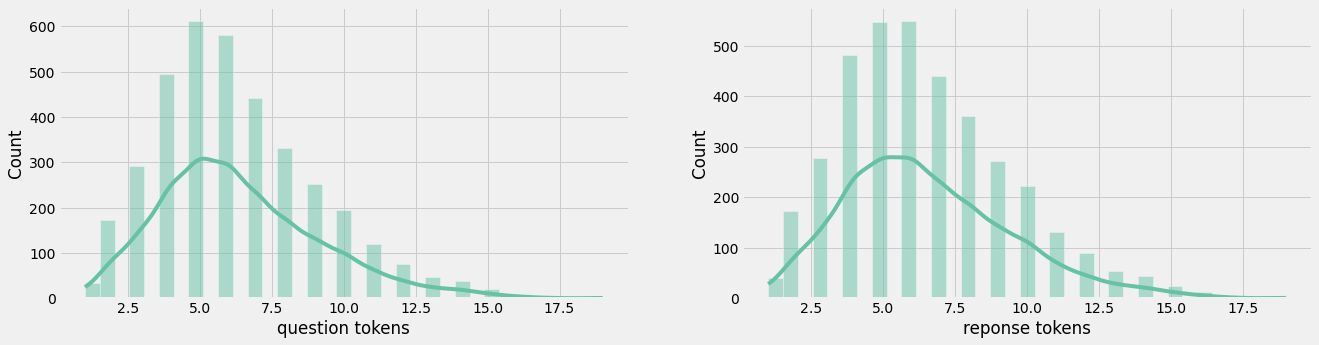

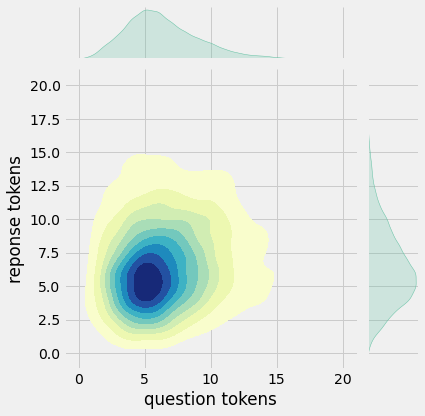

In [7]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['reponse tokens'],data=df,kde=True,ax=ax[1])
sns.jointplot(x='question tokens',y='reponse tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

### Clean the text

In [8]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

In [9]:
# Dropping Unnecessary Columns
df.drop(columns=['reponse tokens','question tokens'],axis=1,inplace=True)
# Cleaning Text Data
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['reponse'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['reponse'].apply(clean_text)+' <end>'

df.head(10)

,question,reponse,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [10]:
# Counting Tokens in Encoder, Decoder Inputs & Decoder Targets
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))

### Visualizes token distributions in questions and responses, and their density relationship.

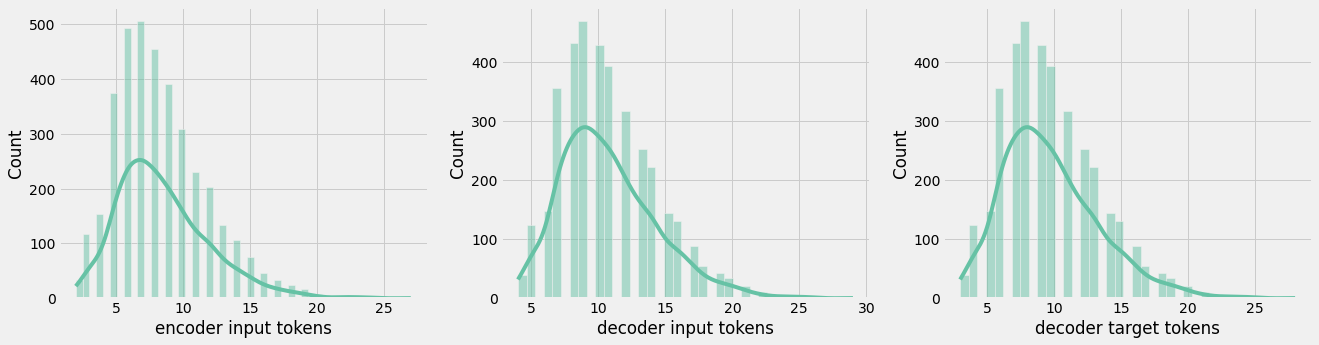

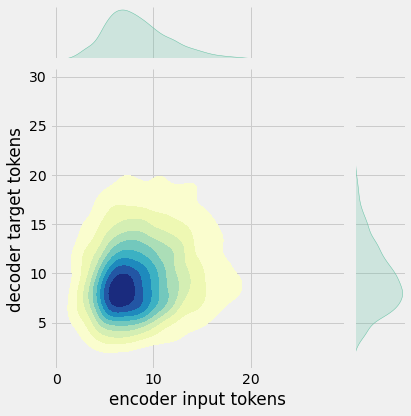

In [11]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [12]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','reponse','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


In [13]:
# Model Parameters & Hyperparameters with LSTM
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']

In [14]:
df.head(10)

,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


## Tokenization

### Configures text vectorization, adapting it to both inputs and targets, and displays the updated vocabulary size and top tokens.

In [15]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


### Converts text to IDs and back, showcasing shapes of model inputs and outputs.

In [16]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: Qui sont les personnes qui travaillent la terre ?')
print(f'Question to tokens: {sequences2ids("Qui sont les personnes qui travaillent la terre ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: Qui sont les personnes qui travaillent la terre ?
Question to tokens: [1 1 1 1 1 1 1 1 7 0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [17]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


### Prepares training and validation datasets, details data batching and shapes.

In [18]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


## Build Models

### Build Encoder

### Defines an Encoder class for a Seq2Seq model, embedding inputs and processing them through LSTM.

In [19]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[-0.14849703, -0.10143437,  0.14909694, ...,  0.02666095,
         -0.15304948, -0.01576973],
        [-0.15792117, -0.09079886,  0.13864629, ..., -0.13165917,
         -0.18846266, -0.05442176],
        [ 0.03792579, -0.20012973,  0.04539509, ..., -0.16405167,
         -0.12270899,  0.00458029],
        ...,
        [ 0.03513838, -0.01939048,  0.22397782, ..., -0.00337751,
         -0.09864788,  0.11941673],
        [-0.03229174,  0.05202373,  0.17214736, ..., -0.04957693,
         -0.11297611,  0.0395298 ],
        [-0.00598205,  0.05221517,  0.13207771, ..., -0.04070636,
          0.06201091,  0.11376796]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[-0.32413122, -0.25286725,  0.4160061 , ...,  0.06902198,
         -0.25806105, -0.05547637],
        [-0.3600886 , -0.21631916,  0.357581  , ..., -0.31882107,
         -0.31916732, -0.19353408],
        [ 0.08261196, -0.5332491 ,  0.11969768,

### Build Decoder

### Implements a Decoder class with embedding, LSTM, and dense layers, integrating encoder states for Seq2Seq processing.

In [20]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[2.2047479e-05, 2.0607359e-04, 1.4624641e-04, ...,
         2.3886653e-04, 1.5233878e-05, 3.4265962e-05],
        [1.5873457e-05, 3.1189826e-05, 8.2115456e-04, ...,
         1.0870545e-04, 1.2723108e-04, 6.5970606e-05],
        [9.0305301e-05, 7.0149450e-05, 6.6287722e-04, ...,
         1.4452734e-04, 1.0514602e-04, 2.5434855e-03],
        ...,
        [5.6956289e-04, 4.6631039e-04, 1.5508432e-04, ...,
         2.5913026e-04, 3.6108674e-04, 8.3758991e-04],
        [5.6956289e-04, 4.6631039e-04, 1.5508432e-04, ...,
         2.5913026e-04, 3.6108677e-04, 8.3758991e-04],
        [5.6956289e-04, 4.6631039e-04, 1.5508432e-04, ...,
         2.5913026e-04, 3.6108674e-04, 8.3758991e-04]]], dtype=float32)>

### Build Training Model

### Integrates Encoder and Decoder into a ChatBotTrainer model, including custom training, testing, and metric evaluation logic.

In [21]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

### Configures and compiles the ChatBotTrainer model for training, setting up loss function, optimizer, and metrics.

In [22]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[2.20474903e-05, 2.06073484e-04, 1.46246268e-04, ...,
         2.38866429e-04, 1.52338707e-05, 3.42659769e-05],
        [1.58734474e-05, 3.11897966e-05, 8.21153575e-04, ...,
         1.08705390e-04, 1.27231004e-04, 6.59706711e-05],
        [9.03052787e-05, 7.01494937e-05, 6.62877108e-04, ...,
         1.44527367e-04, 1.05146151e-04, 2.54348782e-03],
        ...,
        [5.69563184e-04, 4.66309895e-04, 1.55084068e-04, ...,
         2.59130233e-04, 3.61086451e-04, 8.37590196e-04],
        [5.69563184e-04, 4.66309895e-04, 1.55084068e-04, ...,
         2.59130233e-04, 3.61086451e-04, 8.37590196e-04],
        [5.69563184e-04, 4.66309895e-04, 1.55084068e-04, ...,
         2.59130233e-04, 3.61086451e-04, 8.37590196e-04]],

       [[1.41835135e-05, 2.51267484e-04, 2.41358503e-04, ...,
         1.32705987e-04, 2.51572092e-05, 3.81415484e-05],
        [8.76814647e-06, 3.16503341e-04, 2.16256420e-04, ...,
         1.89764774e-04, 6

## Train Model

In [23]:
history=model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/100


KeyboardInterrupt: 

## Visualize Metrics

In [ ]:
# Printing the model summary
model.summary()

### Visualizes training loss and accuracy metrics over epochs, comparing performance on both training and validation data.

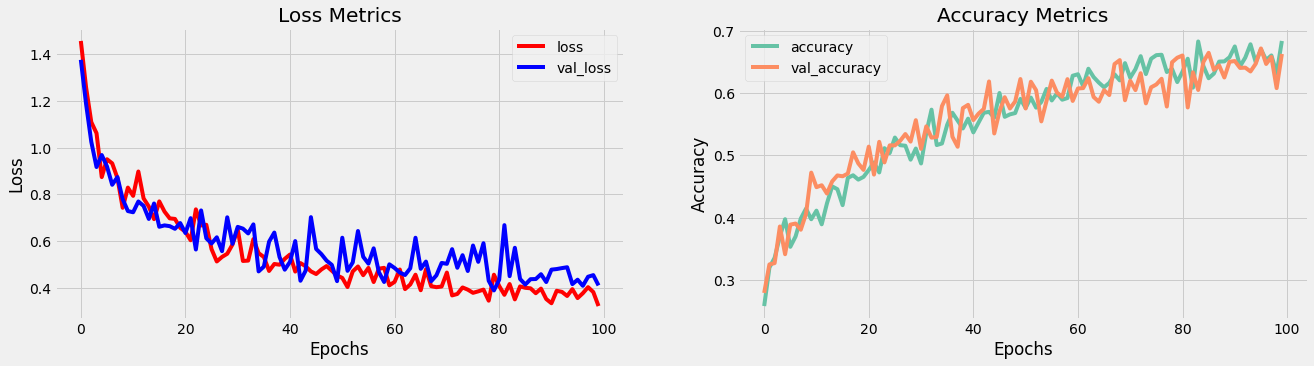

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Save Model

In [ ]:
import os

cwd = os.getcwd()

# model.load_weights(cwd+'/ckpt')
# model.save('models',save_format='tf')
model.save('saved_model/my_model')
model.save('my_model.h5')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


### Enumerates and prints the layers within the Encoder and Decoder components of the ChatBotTrainer model, providing a structured overview.

In [ ]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


## Create Inference Model

### Builds an Inference model for the ChatBot, using the trained Encoder and Decoder models to predict responses.

In [ ]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

In [ ]:
chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        625408    
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,151,232
Trainable params: 1,151,232

In [ ]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

## Test ChatBot

In [ ]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [ ]:
print_conversation([
    'hi, how are you doing?	',
    'do yo know me?',
    'what is your name?',
    'you are bot?',
    'hi, how are you doing?',
    "i'm pretty good. thanks for asking.",
    "Don't ever be in a hurry",
    '''I'm gonna put some dirt in your eye ''',
    '''You're trash ''',
    '''I've read all your research on nano-technology ''',
    '''You want forgiveness? Get religion''',
    '''While you're using the bathroom, i'll order some food.''',
    '''Wow! that's terrible.''',
    '''We'll be here forever.''',
    '''I need something that's reliable.''',
    '''A speeding car ran a red light, killing the girl.''',
    '''Tomorrow we'll have rice and fish for lunch.''',
    '''I like this restaurant because they give you free bread.'''
])

You: hi, how are you doing?	
Bot: i'm fine to the movies. i'm not sure. 
You: do yo know me?
Bot: because you get to meet a lot of money. 
You: what is your name?
Bot: they're in the parking lot. 
You: you are bot?
Bot: i'm not sure. i'm not going to eat. 
You: hi, how are you doing?
Bot: i'm fine. how about you? 
You: i'm pretty good. thanks for asking.
Bot: what does it do? 
You: Don't ever be in a hurry
Bot: i don't have any idea. 
You: I'm gonna put some dirt in your eye 
Bot: no problem. 
You: You're trash 
Bot: i'm going to dinner. 
You: I've read all your research on nano-technology 
Bot: that's a nice restaurant. 
You: You want forgiveness? Get religion
Bot: no, i don't. it's one on the dining. 
You: While you're using the bathroom, i'll order some food.
Bot: don't order you in a hurry when you don't date. 
You: Wow! that's terrible.
Bot: never park your car under a tree. 
You: We'll be here forever.
Bot: we'll be eating peanut butter sandwiches? 
You: I need something that's r